# Term Project - CS329E
#### University Of Texas at Austin
#### 30 November 2021 
#### Contributors: Keigan Kincaid  and Joshua Oh 

## Research Question:
## Is it possible to develop an accurate classifier that determines severity of injury for fixed wing aircraft incidents?

### What is our dataset about?

The NTSB aviation accident database contains information from 1962 and later about civil aviation accidents and selected incidents within the United States, its territories, and possessions, and in international waters. 

A preliminary report is available online within a few days of an accident. Information is added when available, and when the investigation is completed, the preliminary report is replaced with a final description of the accident and its probable cause. The dataset is updated monthly in Microsoft Access 2000 MDB format. 

For this project we decided to use a version of the dataset only including incidents from 2008 to the Present. Our decision for this was largely because the datasets before 2008 did not distinguish whether the event represented the pilot controlling the aircraft at the time or whether the event index was associate with co-pilots, crew, or passengers’ injuries or related statistics.

To appropriately address our research question and reduce our sample size from over 100,000 events to around 8000. The dataset was originally cleaned via Excel in the Microsoft Access 2000 MDB format. From there we selected the appropriate variables and compiled them into a single Excel file where we were able to remove repeats, and null values. Finally, we saved this subset of the original Microsoft Access Database in a CSV format.


### Information Regarding Data Cleaning

As our dataset was around 8000 observations, we utilized a randomized sample of 2000 observations. We then split this sample into an 75-25 split to test and train our classifiers.

### Research Question, What we hope to learn from data, and Learning models implemented

Research Question: Is it possible to develop an accurate classifier that determines severity of injury for fixed wing aircraft incidents?

In this study, we hope to create a model that can classify injury level based upon pilot age (measured in years), and experience (measured in flight hours).

It is important to note that flight hours are measured by the number of hours a pilot has been operating an aircraft, which is kept in a log and verified in annual inspections by a third party to ensure the airworthiness of the vehicle, along with its pilot. Further hours may be logged while completing training exercises as a co-pilot or with guided instruction for a CFI (Certified Flight Instructor.) 

Time logged in simulators or ground school are not included in pilot flight hours. In this study we are looking to use an industry standard classifier (the SVM) to help predict pilot crash severity. The four classifiers we will be using are Logistric Regression, SVM SVC, SVM SVC Linear Regression, and a Gradient Descent/Hinge Loss function without using libraries.

### Expectations Regarding Results Prior to Study

Generally, we expect that younger pilots with less hours will be more reckless than those with more experience and more time in the cockpit. This inexperience is a key factor in why we believe these pilots will be responsible for a larger portion of fixed wing aviation incidents.

#### How we would like our project to be evaluated, How to assess correctness of our models, Thoughts on our models success prior to study

It is important to consider that we are only using two features to classify these events. That being Flight Hours and Age. There are many more features that play a part in aviation incidents which could contribute to aviation incidents.

We expect our model to perform better than a random chance algorithm, that is 51% or better. We do not expect there to be a large difference in the implementations, however we do believe that our dataset is not perfect. For future research, it could be useful to compare other models and include more features. Adding more features may improve the accuracy of our models, avoiding blatant representations such as engine failure, severe weather conditions, or drug/alcohol use.

### Results

Our final results show that with Logistic Regression and the standard Sci-Kit Learn SVM SVC, we have an accurary ~ 50%, while our Linear SVM SVC has an accurary slightly > 50%, and SVM without libraries struggles to reach an accuracy score over 10-15%.

### What can you do to improve your results? What are limitations of your implementations or dataset?

We believe cleaning and analyzing the data would improve the results. We believe their are outliers in the data that are lowering our model's accuracy. Furthermore, there are limited amounts of features that we used to develop our classifier. Looking into the the NTSB Aviation Accident Database and picking more correlating features may help to improve our model. Additionally, many of the outliers in our data are present due to deciding to keep both private and commercial flight data in our dataset. Splitting these data groups up may also help to improve our model. 

### Ideas Applied to improve results:

We decided to utilize Linear SVM SVC because it is more accurate for larger datasets. We can observe that this particular model was more accurate than the other models implemented.

### Describe Code and Implementations:

Our code and implementations are commented below.

### References: 

NTSB Aviation Accident Database:
https://data.ntsb.gov/avdata

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

# Enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

In [128]:
# loading in our crash data then shuffle the dataset so that it is difference each time we run the code
crash_df_raw = pd.read_csv('crash_Dataset.csv')

# shuffle feature, turn off for testing
crash_df_raw = shuffle(crash_df_raw)

In [129]:
# taking the first 2000 observations from the shuffled dataset
crash_df = crash_df_raw.head(n=2000)
crash_df

,ev_id,crew_age,crew_inj_level,flight_hours
2328,20141028X13749,74,0,3.0
3452,20151014X62259,51,0,288.0
433,20121215X21508,58,1,9.0
2411,20141207X85731,56,0,2.0
7464,20190612X55836,67,3,8.0
...,...,...,...,...
6018,20180112X51351,26,3,10.0
6599,20180711X41922,58,0,400.0
8404,20200912X53150,59,1,15.1
1591,20140513X33323,44,0,6200.0


## Observing Data Distributions

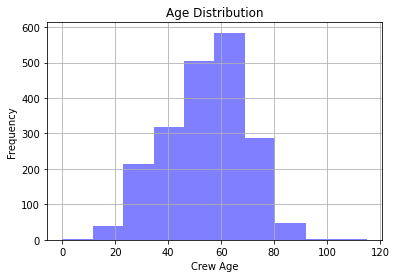

In [130]:
# plot crew_age distribution
plt.hist(crash_df['crew_age'], facecolor='b', alpha=0.50)
plt.xlabel('Crew Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(True)

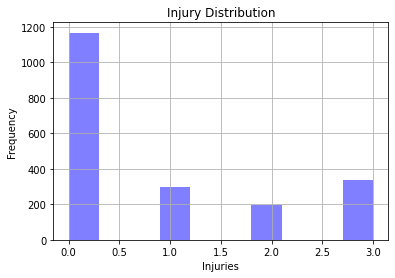

In [131]:
# plot crew_inj_level distribution
plt.hist(crash_df['crew_inj_level'], facecolor='b', alpha=0.50)
plt.xlabel('Injuries')
plt.ylabel('Frequency')
plt.title('Injury Distribution')
plt.grid(True)

# Injury Levels
    # 0 --> None
    # 1 --> Minor 
    # 2 --> Severe
    # 3 --> Fatal

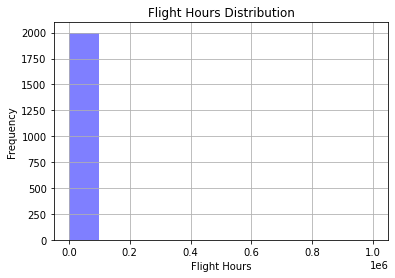

In [173]:
# plot flight_hours distribution
plt.hist(crash_df['flight_hours'], facecolor='b', alpha=0.50)
plt.xlabel('Flight Hours')
plt.ylabel('Frequency')
plt.title('Flight Hours Distribution')
plt.grid(True)

# data range for flight hours is massive, can result in unreadable histogram

1445.1074503554316


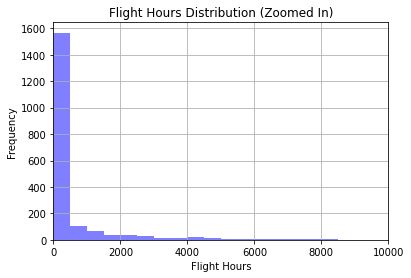

In [172]:
# plot flight_hours distribution zoomed in
plt.hist(crash_df['flight_hours'], bins=2000, facecolor='b', alpha=0.50)
plt.xlabel('Flight Hours')
plt.ylabel('Frequency')
plt.xlim(0, 10000)
plt.title('Flight Hours Distribution (Zoomed In)')
plt.grid(True)

# identifying the average flight hour value
print(np.mean(crash_df['flight_hours']))

## Splitting Dataset

In [133]:
# splitting into features and targets, X and Y respectively
X = crash_df[['crew_age', 'flight_hours']]
Y = crash_df['crew_inj_level']

# splitting the data into testing and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=512)

# re-indexing in dataframe
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)

# printing shapes of Target training and test data
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1500, 2)
(1500,)
(500, 2)
(500,)


## Logistic Regression

In [134]:
model = LogisticRegression(C=.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(Y_test, y_pred), "\n")

print(classification_report(Y_test, y_pred))

Accuracy Score: 0.618 

              precision    recall  f1-score   support

           0       0.62      0.99      0.76       304
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00        52
           3       0.54      0.10      0.16        73

    accuracy                           0.62       500
   macro avg       0.29      0.27      0.23       500
weighted avg       0.46      0.62      0.49       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: Unde

## Implementation of SVM using Libraries

In [135]:
model = svm.SVC(C=.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [136]:
print("Accuracy Score:", accuracy_score(Y_test, y_pred), "\n")

print(classification_report(Y_test, y_pred))

Accuracy Score: 0.608 

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       304
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        73

    accuracy                           0.61       500
   macro avg       0.15      0.25      0.19       500
weighted avg       0.37      0.61      0.46       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: Unde

## Implementation of Linear SVC using Libraries

In [137]:
model = svm.LinearSVC(C=.01, max_iter=300, fit_intercept=False)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(Y_test, y_pred))

# from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

Accuracy Score: 0.516
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       304
           1       0.14      0.28      0.18        71
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        73

    accuracy                           0.52       500
   macro avg       0.20      0.27      0.23       500
weighted avg       0.43      0.52      0.47       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

## Implementation of SVM without Libraries

### Function Predict SVM for Comparing Accuracy of Classifiers

In [138]:
def predict_svm(weights, X):
    """
    Predict the class between 0 and 1 using learned SVM parameters weights.
    """    
    return np.where(np.dot(X, weights)<0, -1, 1)

In [139]:
def compute_cost(X, y, W, regularization_factor):
    '''This function calculate the hinge loss. Primal Problem in SVM'''
    n = X.shape[0]
    distances = 1 - y * (np.dot(X, W))
    
    # This is our max(0, distance). 
    distances[distances < 0] = 0 
    
    hinge_loss = regularization_factor * (np.sum(distances) / n)
    # This divide by 2 is not important. You can skip doing it 
    # because we want only to check if this cost is going down or not. 
    return (1 / 2 * np.dot(W, W) + hinge_loss)

In [140]:
def calculate_gradient(X, y, W, regularization_factor):
      
    if type(y) == np.float64:
        y = np.array([y])
        X = np.array([X])
        
    distance = 1 - (y * np.dot(X, W))
    
    dw = np.zeros(len(W))
    
    for ind, d in enumerate(distance):
        
        if (d < 0):
            di = W
        else:
            di = W - (regularization_factor * y[ind] * X.loc[ind])
            
        dw += di
    
    dw = dw/len(y)  # average
    
    return dw

In [141]:
# adding column of ones for matrix multiplication (dot product)
x_0 = [1]*len(X_train)
X_train['x_0'] = x_0
X_train = X_train[['x_0', 'crew_age', 'flight_hours']]

x_01 = [1]*len(X_test)
X_test['x_0'] = x_01
X_test = X_test[['x_0', 'crew_age', 'flight_hours']]

In [142]:
# same length as previous matrices
# y intercept is the b, must have one additional and add to x column of 1s
# logistic reg and support vector having 1 additional 
# ex 16 or 16 1
weights = np.zeros(3)

# Now we optimize it using Gradient Descent. 
num_iterations = 20
learning_rate = 0.001
regularization = 0.01

cost_list = []

for i in range(0, num_iterations):
    
    # current iteration cost
    cost = compute_cost(X_train, Y_train, weights, regularization)
    
    print("Epoch", i, "Cost is:", cost, "\n", "Weights:\n", weights)
    print("Accuracy Score:", accuracy_score(Y_test, predict_svm(weights, X_test)), "\n")
    
    # appending current iteration cost
    cost_list.append(cost)
    
    # gradient descent (optimization)
    grad = calculate_gradient(X_train, Y_train, weights, regularization)
    
    # updating the weights
    weights = weights - learning_rate * grad

Epoch 0 Cost is: 0.01 
 Weights:
 [0. 0. 0.]
Accuracy Score: 0.142 

Epoch 1 Cost is: 0.007754323494774965 
 Weights:
 x_0             0.000009
crew_age        0.000490
flight_hours    0.028225
Name: 0, dtype: float64
Accuracy Score: 0.142 

Epoch 2 Cost is: 0.00771503227937603 
 Weights:
 x_0             0.000012
crew_age        0.000688
flight_hours    0.028209
Name: 0, dtype: float64
Accuracy Score: 0.142 

Epoch 3 Cost is: 0.007675836083986081 
 Weights:
 x_0             0.000016
crew_age        0.000885
flight_hours    0.028193
Name: 0, dtype: float64
Accuracy Score: 0.142 

Epoch 4 Cost is: 0.007637264293170427 
 Weights:
 x_0             0.000019
crew_age        0.001081
flight_hours    0.028177
Name: 0, dtype: float64
Accuracy Score: 0.142 

Epoch 5 Cost is: 0.007599251799271649 
 Weights:
 x_0             0.000023
crew_age        0.001275
flight_hours    0.028161
Name: 0, dtype: float64
Accuracy Score: 0.142 

Epoch 6 Cost is: 0.0075614572391117995 
 Weights:
 x_0             

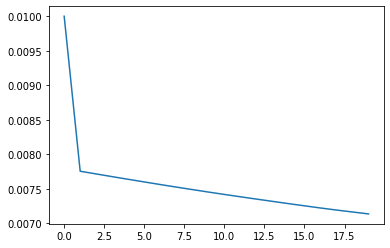

In [143]:
# plot cost per iteration
plt.plot(np.arange(num_iterations), cost_list)
plt.show()

In [144]:
print("Accuracy Score:", accuracy_score(Y_test, predict_svm(weights, X_test)) *100, '%')

print(classification_report(Y_test, predict_svm(weights, X_test)))

Accuracy Score: 14.2 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       304
           1       0.14      1.00      0.25        71
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        73

    accuracy                           0.14       500
   macro avg       0.04      0.25      0.06       500
weighted avg       0.02      0.14      0.04       500



C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1308: Unde